In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from deepjets import learning, models, preprocessing, utils

In [26]:
model = models.get_maxout(25**2)
history = learning.train_model(
    model, 'datasets/w_ns_mslice_mini_train.h5', 'models/w_ns_mslice_mini',
    epochs=50, patience=0, verbose=1, lr_scale_factor=0.9, log_to_file=True)

Train on 18000 samples, validate on 2000 samples
Epoch 1/50
18000/18000 [==============================] - 4s - loss: 0.6809 - val_loss: 0.6041
Epoch 00000: val_loss improved from inf to 0.60405, saving model to models/w_ns_mslice_mini_weights.h5
Epoch 2/50
18000/18000 [==============================] - 4s - loss: 0.5678 - val_loss: 0.5384
Epoch 00001: val_loss improved from 0.60405 to 0.53841, saving model to models/w_ns_mslice_mini_weights.h5
Epoch 3/50
18000/18000 [==============================] - 5s - loss: 0.5265 - val_loss: 0.5117
Epoch 00002: val_loss improved from 0.53841 to 0.51173, saving model to models/w_ns_mslice_mini_weights.h5
Epoch 4/50
18000/18000 [==============================] - 9s - loss: 0.5051 - val_loss: 0.5092
Epoch 00003: val_loss improved from 0.51173 to 0.50919, saving model to models/w_ns_mslice_mini_weights.h5
Epoch 5/50
18000/18000 [==============================] - 10s - loss: 0.4887 - val_loss: 0.4969
Epoch 00004: val_loss improved from 0.50919 to 0.49

Testing on 20000 samples.
Dataset from datasets/w_ns_mslice_mini_test.h5.
Score    = 0.433435060084
ROC AUC  = 0.934415879908
Accuracy = 16171/20000 = 0.80855



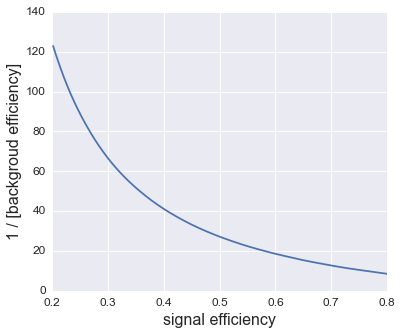

In [11]:
roc = learning.test_model(models.load_model('models/w_ns_mslice_mini'),
                          'datasets/w_ns_mslice_mini_test.h5', show_roc_curve=True)
# Cross-validation early stopping